# **Image-based Ingredients Classification**

In this project, our goal is to detect the ingredients based on the image dataset. The image dataset includes 101000 images from 101 categories. There is another dataset called *Ingredients101* which holds ingredients information for each images. In the following steps, the materials used in the project are explained in detail.

# Used libraries

In [1]:
import os
import zipfile
import gdown
%matplotlib inline
import sys
import cv2
import numpy as np
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm, tqdm_notebook, tnrange
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict
import warnings
from tables import NaturalNameWarning

**os**: Provides a way to interact with the operating system, including file and directory operations.

**zipfile**: Allows for reading and writing ZIP archives, which are compressed files containing one or more files.

**gdown**: A module to download files from Google Drive using their URL.

**sys**: Provides access to some variables used or maintained by the Python interpreter and to functions that interact strongly with the interpreter.

**cv2 (OpenCV)**: A library of programming functions mainly aimed at real-time computer vision. It is used for image processing and computer vision tasks.

**numpy (np)**: A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

**torch**: The main package for PyTorch, an open-source machine learning library based on the Torch library, used for applications such as natural language processing.

**torch.utils.data**: A subpackage in PyTorch that provides tools for loading data, such as datasets and dataloaders, to feed into models.

**torch.autograd**: A PyTorch package for automatic differentiation. It records operations performed on tensors to compute gradients for optimization.

**torch.nn**: A subpackage in PyTorch that provides neural network layers and functions. It includes various modules and loss functions.

**torchvision.datasets**: A package that provides standard datasets for computer vision, such as CIFAR-10, MNIST, and ImageNet.

**torchvision.transforms**: A module that provides common image transformations for preprocessing data, such as resizing, cropping, and normalization.

**glob**: A module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.

**pandas (pd)**: A library providing high-performance, easy-to-use data structures and data analysis tools for Python. It is particularly useful for handling structured data.

**matplotlib.pyplot**: A module in Matplotlib, a plotting library for creating static, interactive, and animated visualizations in Python. pyplot provides a MATLAB-like interface.

**torchvision.models**: A module that includes pre-trained models such as VGG, ResNet, and others for tasks like image classification.

**sklearn.preprocessing.MultiLabelBinarizer**: A tool from scikit-learn (a machine learning library) that transforms a list of labels into a binary matrix for multi-label classification.

**tqdm, tqdm_notebook, tnrange**: Modules that provide fast, extensible progress bars for loops. tqdm_notebook and tnrange are specific to Jupyter notebooks.

**torch.nn.functional**: Provides tensor operations for neural network layers.

**sklearn.metrics**: Offers functions to evaluate the performance of machine learning models.

**collections.defaultdict**: Enhances dictionaries by providing default values for non-existent keys.

# Setting up the environment and downloading necessary datasets

By using os library, Kaggle API and shell command, necessary datasets are downloaded.

We are importing the OS module, which provides a portable way to interact with the operating system. We use it to set environment variables and execute shell commands.

The part sets environment variables for the Kaggle API credentials. Kaggle API requires authentication, so we set the KAGGLE_USERNAME and KAGGLE_KEY environment variables to the appropriate values.

In [2]:
# Set Kaggle API credentials environment variables
os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

# Download the dataset
dataset_name = "kmader/food41"  # Replace with the username and dataset name
os.system(f"kaggle datasets download -d {dataset_name}")
print("Download completed!")


Download completed!


unzip_file method takes a file path and an extraction path as parameter. It unzips the given zip file to a specific path mentioned.

In [3]:
def unzip_file(zip_file_path, extract_to_path):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
"""
    Unzips a ZIP file to a specified directory.

    Parameters:
        zip_file_path (str): The path to the ZIP file.
        extract_to_path (str): The directory where the contents of the ZIP file will be extracted.

    Returns:
        None
"""

# Example usage:
zip_file_path = '/content/food41.zip'
rootfolder = '/content/food41'
unzip_file(zip_file_path, rootfolder)
print("Dataset is unzipped!")

Dataset is unzipped!


By using gdown library, we download Ingredients101 dataset from Google Drive.

In [4]:
# URL of the first file
url_ingredients101 = 'https://drive.google.com/uc?id=14ztu2gjdowZdMdCvo1tAZJ0aK5rMs4kb'

# Destination path for the first file
output1 = 'Ingredients101.zip'

# Download the first file
gdown.download(url_ingredients101, output1, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14ztu2gjdowZdMdCvo1tAZJ0aK5rMs4kb
To: /content/Ingredients101.zip
100%|██████████| 1.79M/1.79M [00:00<00:00, 124MB/s]


'Ingredients101.zip'

After downloading Ingredients101, we unzip it by using unzip_file function.

In [5]:
# Define the paths to the zip files
zip_file1 = 'Ingredients101.zip'

# Define the directory to extract the files to
extract_dir1 = 'Ingredients101'

# Create directories if they don't exist
os.makedirs(extract_dir1, exist_ok=True)

# Extract the first zip file
unzip_file(zip_file1, extract_dir1)

print("Extraction completed.")

Extraction completed.


This code deletes the ZIP file named 'Ingredients101.zip' from the current directory for saving the space in google colab to work it efficiently.

In [6]:
# Delete the zip file
os.remove('Ingredients101.zip')

print("Zip files deleted.")

Zip files deleted.


# Preprocessing ingredients dataset

For this project, since the datasets are too large files to work with, using cuda or GPU is highly required.

In [7]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42)
BASE_PATH = '../content/Ingredients101/Ingredients101'

In [8]:
print(os.listdir("../content/food41/images/"))

MICRO_DATA = True # debugging the model with minimal subset of the data
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (384, 384) # ensure that all images are in a standard size

['bruschetta', 'pizza', 'red_velvet_cake', 'creme_brulee', 'bibimbap', 'risotto', 'peking_duck', 'churros', 'spaghetti_bolognese', 'seaweed_salad', 'french_toast', 'fried_calamari', 'cheese_plate', 'lobster_roll_sandwich', 'pulled_pork_sandwich', 'cup_cakes', 'ceviche', 'caprese_salad', 'gnocchi', 'strawberry_shortcake', 'tiramisu', 'sushi', 'filet_mignon', 'beef_tartare', 'lobster_bisque', 'apple_pie', 'shrimp_and_grits', 'scallops', 'takoyaki', 'cheesecake', 'gyoza', 'carrot_cake', 'greek_salad', 'chicken_curry', 'baklava', 'escargots', 'panna_cotta', 'frozen_yogurt', 'hummus', 'garlic_bread', 'chicken_wings', 'waffles', 'chocolate_cake', 'deviled_eggs', 'samosa', 'grilled_salmon', 'hot_dog', 'beef_carpaccio', 'macarons', 'oysters', 'huevos_rancheros', 'foie_gras', 'pancakes', 'chocolate_mousse', 'ramen', 'hot_and_sour_soup', 'tuna_tartare', 'tacos', 'clam_chowder', 'french_fries', 'hamburger', 'falafel', 'macaroni_and_cheese', 'ravioli', 'steak', 'beet_salad', 'fish_and_chips', 'cra

 Here we are reading the contents of the 'ingredients_simplified.txt' file, which contains a list of ingredients, and splits it into individual ingredient names stored in the ingredients list.

In [9]:
#Ingredients for each class
f = open('/content/Ingredients101/Ingredients101/Annotations/ingredients_simplified.txt', "r")
ingredients = f.read().split('\n')
f.close()

Here we are reading the contents of the 'classes.txt' file, which contains a list of class names, and splits it into individual class names stored in the classes list.

In [10]:
#Classes
f = open('/content/Ingredients101/Ingredients101/Annotations/classes.txt', "r")
classes = f.read().split('\n')
f.close()

This code reads the contents of the 'baseIngredients.txt' file, which contains a list of base ingredients, and splits it into individual base ingredient names stored in the base_ing list. Finally, it closes the file after reading.

In [11]:
#Base Ingredients
f = open('/content/Ingredients101/Ingredients101/ingredients_simplification/baseIngredients.txt', "r")
base_ing = f.read().split('\n')
f.close()

In [12]:
# Print the read files
base_ing
ingredients
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

We split each string in the ingredients list by commas and creates a new list called new_ingredients containing these split strings. Essentially, it's breaking down each ingredient name that might have multiple components separated by commas into individual components and storing them as sublists within the new_ingredients list.

In [13]:
new_ingredients = []
for arr in ingredients:
    arr = arr.split(",")
    new_ingredients.append(arr)
new_ingredients

[['butter', 'flour', 'sugar', 'brown sugar', 'apple', 'cinnamon', 'nut'],
 ['baby back ribs',
  'apple',
  'salt',
  'mustard',
  'brown sugar',
  'worcestershire',
  'gin',
  'chili'],
 ['nut',
  'cinnamon',
  'bread',
  'butter',
  'phyllo dough',
  'sugar',
  'honey',
  'lemon',
  'baklava'],
 ['beef', 'lemon', 'gin', 'salt', 'pepper', 'baby arugula', 'asiago'],
 ['fat',
  'steak',
  'gin',
  'shallot',
  'parsley',
  'capers',
  'worcestershire',
  'egg',
  'black pepper',
  'crostini'],
 ['beets',
  'spinach',
  'gorgonzola',
  'nut',
  'red wine',
  'dijon mustard',
  'gin',
  'salt',
  'black pepper',
  'herbs'],
 ['water',
  'sugar',
  'yeast',
  'egg',
  'salt',
  'milk',
  'butter',
  'flour',
  'sugar'],
 ['grain',
  'steak',
  'soybean sprouts',
  'spinach',
  'cucumber',
  'zucchini',
  'carrot',
  'garlic',
  'scallions',
  'soy',
  'oil',
  'seeds',
  'salt',
  'pepper',
  'oil',
  'egg',
  'pepper',
  'sugar',
  'water'],
 ['bread', 'milk', 'sugar', 'butter', 'salt', 'e

# Binarization

We use MultiLabelBinarizer to convert the list of ingredient lists (new_ingredients) into a binary matrix format. Each ingredient becomes a binary feature column in the resulting DataFrame (df), where the presence or absence of an ingredient is represented by 1 or 0 respectively.

In [14]:
mlb = MultiLabelBinarizer()

df = pd.DataFrame(mlb.fit_transform(new_ingredients),columns=mlb.classes_) #binary encode ingredients

This code adds a new column named "target" to df, populated with the class names from the classes list, creating a dictionary-like representation of the binary-encoded food ingredients dataset.

In [15]:
df["target"] = classes
food_dict = df

We read the paths to train, validation, and test images and their corresponding labels from separate text files. It splits the content of each file by newline characters ('\n') and stores them in lists.

In [16]:
#Training part
f = open(BASE_PATH + '/Annotations/train_images.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/Annotations/train_labels.txt', "r")
train_labels = f.read().split('\n')
f.close()

#Validation part
f = open(BASE_PATH + '/Annotations/val_images.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/Annotations/val_labels.txt', "r")
val_labels = f.read().split('\n')
f.close()

#Test part
f = open(BASE_PATH + '/Annotations/test_images.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/Annotations/test_labels.txt', "r")
test_labels = f.read().split('\n')
f.close()

In [17]:
#train_images
len(train_labels)

68176

This code constructs df representations (all_img_df, val_img_df, test_img_df) for the training, validation, and test datasets. It creates paths to image files by appending '.jpg' extension to each image name in the lists, and then associates each image path with its corresponding class ID from train_labels, val_labels, and test_labels within dataframes.

In [18]:
train_images = ["../content/food41/images/" + s + ".jpg" for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})
val_images = ["../content/food41/images/" + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})
test_images = ["../content/food41/images/" + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})

This chunk of code removes the last row from each df. It's done to handle empty or incomplete entries that might have been introduced while reading the image paths and labels from the text files.

In [19]:
all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]

This chunk of code adds a new column named 'class_name' to each df. It derives the class name for each image path by extracting the last directory name from the path using *os.path.split(os.path.dirname(x))[-1]*. This lambda function is applied to the 'path' column of each df, resulting in the class name being extracted and added as a new column.

In [20]:
all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])

The drop() function is called with axis=1 to specify that the operation should be performed along columns and the empty string '' indicates the column name to be dropped.

In [21]:
food_dict = food_dict.drop('', axis=1)

In [22]:
food_dict.head()

,adobo,almond,anaheim chile,anchovy,anise,apple,arborio rice,asiago,avocado,baby arugula,...,vermouth,vinegar,water,wheat tortillas,whipping,white wine,worcestershire,yeast,zucchini,target
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,apple_pie
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,baby_back_ribs
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,baklava
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,beef_carpaccio
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,beef_tartare


We iterate over each row in all_img_df, representing training images. For each row:
- It extracts the food class name, image path and class ID.
- It looks up the binary encoding of the food class from food_dict.
- It adds the image path and class ID to the binary encoding df.
- It converts the resulting row into a numpy array and appends it to the new_data list. This process effectively creates a new dataset where each row represents a training image along with its binary-encoded food class information.

In [23]:
# DataFrame for train images
new_data = []
for index, row in all_img_df.iterrows():
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food].copy()  # Make a copy of the matched row
    binary_encod.loc[:, "path"] = path
    binary_encod.loc[:, "class_id"] = class_id
    new_data.append(np.array(binary_encod.iloc[0]))

# Convert new_data to DataFrame
new_data_df = pd.DataFrame(new_data, columns=binary_encod.columns)

This code creates a DataFrame train_df using the list new_data, where each row represents a training image with its corresponding binary-encoded food class information. It ensures that the column names are correctly assigned from the binary_encod DataFrame.

col_names = list(binary_encod.columns.values): This line retrieves the column names from the binary_encod DataFrame and stores them in the list col_names.


In [24]:
col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)

This code iterates over each row in the DataFrame val_img_df, representing validation images. For each row:
- It extracts the food class name, image path, and class ID.
- It looks up the binary encoding of the food class from the food_dict DataFrame.
- It adds the image path and class ID to the binary encoding DataFrame.
- Finally, it converts the resulting row into a numpy array and appends it to the val_data list. This process effectively creates a new dataset (val_data) where each row represents a validation image along with its binary-encoded food class information.

In [25]:
# DataFrame for val images
val_data = []
for index, row in val_img_df.iterrows():
    # Get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food].copy()  # Make a copy of the matched rows
    binary_encod.loc[:, "path"] = path
    binary_encod.loc[:, "class_id"] = int(class_id)
    val_data.append(np.array(binary_encod.iloc[0]))

# Convert val_data to DataFrame
val_data_df = pd.DataFrame(val_data, columns=binary_encod.columns)

This code constructs val_df using the list val_data, where each row represents a validation image with its corresponding binary-encoded food class information. The column names are derived from the col_names list.

In [26]:
val_df = pd.DataFrame(val_data, columns = col_names)

We iterate over each row in test_img_df, representing test images. For each row:

- It extracts the food class name, image path, and class ID.
- It looks up the binary encoding of the food class from the food_dict DataFrame.
- It adds the image path and class ID to the binary encoding DataFrame.
- Finally, it converts the resulting row into a numpy array and appends it to the test_data list. This process effectively creates a new dataset (test_data) where each row represents a test image along with its binary-encoded food class information.

In [27]:
# DataFrame for test images
test_data = []
for index, row in test_img_df.iterrows():
    # Get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food].copy()  # Make a copy of the matched rows
    binary_encod.loc[:, "path"] = path
    binary_encod.loc[:, "class_id"] = int(class_id)
    test_data.append(np.array(binary_encod.iloc[0]))

# Convert test_data to DataFrame
test_data_df = pd.DataFrame(test_data, columns=binary_encod.columns)


We create test_df using the list test_data, where each row represents a test image with its corresponding binary-encoded food class information. It ensures that the column names are correctly assigned from the col_names list.

In [28]:
test_df = pd.DataFrame(test_data, columns = col_names)

# Convertion to HDF5 format

We save train_df, val_df, and test_df to separate HDF5 files in the current directory.

- .to_hdf() function is used to save the DataFrame to an HDF5 file format.
- The first argument specifies the filename to which the DataFrame will be saved.
- The second argument specifies the key (name) under which the DataFrame will be stored within the HDF5 file.
- mode='w' indicates that if the file already exists, it should be overwritten.
- format='table' specifies the format of the HDF5 file to be 'table'.
- data_columns=True specifies that additional indices should be created for each column to speed up queries.

This allows for efficient storage and retrieval of large datasets.

HDF5 is a file format designed for storing and organizing large amounts of data. HDF5 files can contain datasets, groups, and attributes, and they support efficient data compression and indexing.

In [29]:
# Ignore the NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

# Save the dataframes to HDF5 files
train_df.to_hdf('train_df.h5', 'df', mode='w', format='table', data_columns=True)
val_df.to_hdf('val_df.h5', 'df', mode='w', format='table', data_columns=True)
test_df.to_hdf('test_df.h5', 'df', mode='w', format='table', data_columns=True)


We read train_df and test_df from the HDF5 files "train_df.h5" and "test_df.h5" into memory using the pd.read_hdf() function. This function reads data stored in HDF5 format and returns it as a pandas DataFrame.

In [30]:
train_df = pd.read_hdf("train_df.h5")
test_df = pd.read_hdf("test_df.h5")

In [31]:
print(os.listdir("/content/food41/images"))
epochs = 8
batch_size = 64
SMALL_DATA = False
IMG_SIZE = (384, 384)

['bruschetta', 'pizza', 'red_velvet_cake', 'creme_brulee', 'bibimbap', 'risotto', 'peking_duck', 'churros', 'spaghetti_bolognese', 'seaweed_salad', 'french_toast', 'fried_calamari', 'cheese_plate', 'lobster_roll_sandwich', 'pulled_pork_sandwich', 'cup_cakes', 'ceviche', 'caprese_salad', 'gnocchi', 'strawberry_shortcake', 'tiramisu', 'sushi', 'filet_mignon', 'beef_tartare', 'lobster_bisque', 'apple_pie', 'shrimp_and_grits', 'scallops', 'takoyaki', 'cheesecake', 'gyoza', 'carrot_cake', 'greek_salad', 'chicken_curry', 'baklava', 'escargots', 'panna_cotta', 'frozen_yogurt', 'hummus', 'garlic_bread', 'chicken_wings', 'waffles', 'chocolate_cake', 'deviled_eggs', 'samosa', 'grilled_salmon', 'hot_dog', 'beef_carpaccio', 'macarons', 'oysters', 'huevos_rancheros', 'foie_gras', 'pancakes', 'chocolate_mousse', 'ramen', 'hot_and_sour_soup', 'tuna_tartare', 'tacos', 'clam_chowder', 'french_fries', 'hamburger', 'falafel', 'macaroni_and_cheese', 'ravioli', 'steak', 'beet_salad', 'fish_and_chips', 'cra

The condition if SMALL_DATA: suggests that there might be a variable named SMALL_DATA elsewhere in the code, likely used to determine whether to use a small subset of the data for faster testing or development.

If SMALL_DATA is True, then:

- The first 128 rows of the train_df DataFrame are selected and assigned back to train_df.
- Similarly, the first 128 rows of the val_df DataFrame are selected and assigned back to val_df.
- The first 128 rows of the test_df DataFrame are selected and assigned back to test_df.



In [32]:
train_df = pd.read_hdf("../content/train_df.h5")
val_df = pd.read_hdf("../content/val_df.h5")
test_df = pd.read_hdf("../content/test_df.h5")

if SMALL_DATA:
    train_df = train_df[:128]
    val_df = test_df[:128]
    test_df = actual_test_df[:128]

This line retrieves the column names from the DataFrame train_df and stores them in the list col_names.

In [33]:
col_names = list(train_df.columns.values)

This line assigns the first N-3 column names from col_names to ing_names and then assigns ing_names to targets.

In [34]:
ing_names = col_names[:-3]
targets = ing_names

We define DataWrapper function to use with PyTorch's data loader function.

- __init__ method initializes the dataset with an image DataFrame and a flag for resizing.
- __getitem__ method retrieves an image and its corresponding target labels at a given index.
- Image is read, resized (if specified), and converted to PyTorch tensor format.
- __len__ method returns the total number of samples in the dataset.

In [35]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)
        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        if self.resize:
            image = cv2.resize(image, IMG_SIZE)/255.0
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]

# Working with ResNet-50 model

We work with pre-trained ResNet-50 model and it modifies its final fully connected layer to match the number of target classes.

It then iterates through the child modules of the model.
For the first 7 layers (excluding the final fully connected layer), it freezes the parameters (*params.requires_grad = False*). This means that these layers will not be updated during training, and only the parameters of the final fully connected layer will be optimized.

In [36]:
# Ignore specific warnings
warnings.filterwarnings('ignore', message="The parameter 'pretrained' is deprecated since 0.13")
warnings.filterwarnings('ignore', message="Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13")


# Load the ResNet50 model with pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze layers
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(targets))

ct = 0
for name, child in model.named_children():
    ct += 1
    if ct < 8:
        for name2, params in child.named_parameters():
            params.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


We set up the training, validation, and test datasets and data loaders for a deep learning model using PyTorch.

- **model = model.to(device)**: Moves the model to the specified device (CPU or GPU) for computation.
- **criterion = nn.BCEWithLogitsLoss()**: Defines the loss function, Binary Cross Entropy with Logits Loss, suitable for binary classification tasks.
- **optimizer = torch.optim.Adam(model.parameters())**: Initializes the Adam optimizer to update the parameters of the model during training.
- **train_dataset, val_dataset, test_dataset**: Instances of the DataWrapper class initialized with training, validation, and test DataFrames, respectively, along with a flag indicating whether to resize images.
- **train_loader, val_loader, test_loader**: PyTorch data loaders created from the corresponding datasets, with specified batch size and shuffling. pin_memory is set to False to disable pinning memory, which can improve performance when transferring data between CPU and GPU.

In [37]:
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)

val_dataset = DataWrapper(val_df, True)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=batch_size, pin_memory=False)


We write a function to calculate Hamming score, it is label-based accuracy, for the multi-label classification case. Here's how it works:

- It takes two inputs, y_true and y_pred, which are arrays containing the true and predicted labels for each sample, respectively.
- It iterates over each sample in the dataset.
- For each sample, it calculates the intersection and union of the sets of true and predicted labels.
- It computes the ratio of the size of the intersection to the size of the union, which represents the similarity between the true and predicted label sets.
- It computes the average similarity across all samples and returns it as the Hamming score.

In [38]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None

        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float(len(set_true.union(set_pred)))

        acc_list.append(tmp_a)
    return np.mean(acc_list)

# Train & test with results

We train a neural network model for a specified number of epochs (here set to 2) using training data and evaluates its performance on a validation dataset. During each epoch, it iterates over mini-batches of the training data, computes the loss, and updates the model's parameters using backpropagation. After each epoch, it evaluates the model on the validation dataset and computes various metrics such as F1 score, accuracy, and loss. The model with the best accuracy on the validation set is saved. Finally, it plots the training curves and saves the figure as 'train_curves.png'.



1. Initialization: Initialize necessary variables like train_results, train_iter, test_iter, and best_acc. Set up a plot with subplots for visualizing training and testing metrics.

2. Training Loop: Iterate over a fixed number of epochs (tnrange(2) in this case). Within each epoch:

     - Switch the model to training mode (model.train()).
     - Iterate over mini-batches of the training data (train_loader).
     - Compute forward pass, loss, and gradients, and update model parameters.
     - Track training loss and accuracy.

3. Validation Loop: After each epoch, switch the model to evaluation mode (model.eval()).

      - Iterate over mini-batches of the validation data (val_loader).
      - Compute forward pass and loss without updating parameters.
      - Track validation loss and accuracy.

4. Metrics Computation: After each epoch:

      - Compute various evaluation metrics like F1 score, precision, recall, and Hamming score for both training and validation sets.
      - Store the metrics in train_results and f1_scores.

5. Save Best Model: If the current model achieves a higher accuracy on the validation set than the previous best model, save its parameters as the new best model.

6. Visualization: Plot training curves (loss and accuracy) for both training and validation sets.

7. Save Figures: Save the plot as an image file (train_curves.png).

<ipython-input-39-1fc7f7613545>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(2, desc='Epochs'):  # Set to run only 2 epochs


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  0


<ipython-input-39-1fc7f7613545>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_data, target in tqdm_notebook(train_loader, desc='Training'):


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.00135085291015739  train acc:  0.9698961437994019


<ipython-input-39-1fc7f7613545>:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_data, target in tqdm_notebook(val_loader, desc='Testing'):


Testing:   0%|          | 0/119 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:  0.9757334147511667
Epoch  1


<ipython-input-39-1fc7f7613545>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_data, target in tqdm_notebook(train_loader, desc='Training'):


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training loss:  0.0008738007597272807  train acc:  0.9800465567849003


<ipython-input-39-1fc7f7613545>:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_data, target in tqdm_notebook(val_loader, desc='Testing'):


Testing:   0%|          | 0/119 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:  0.980540556258269


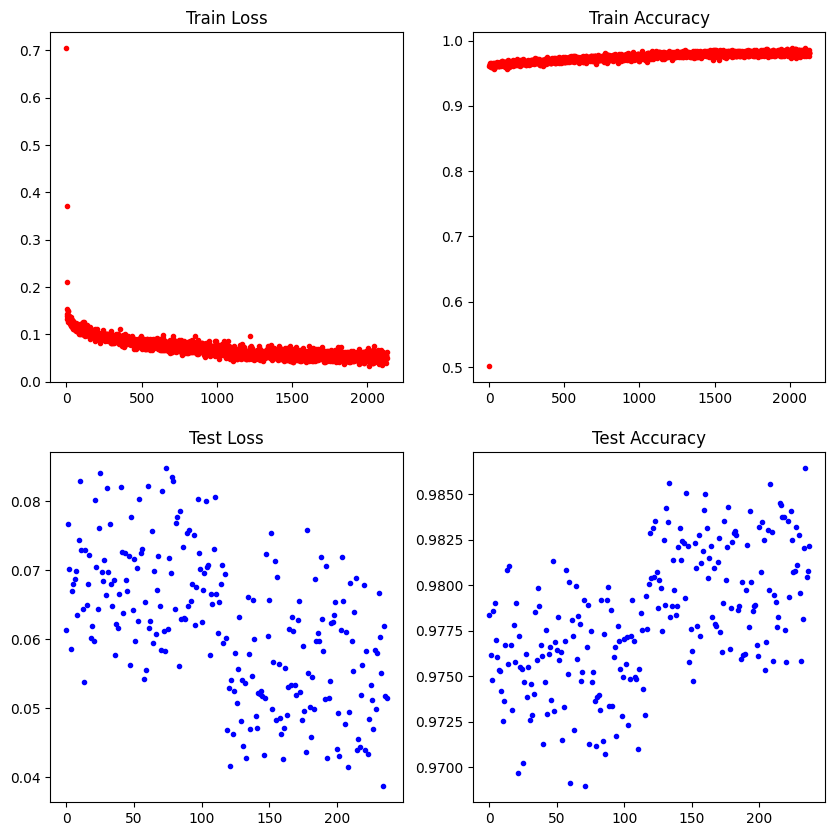

In [39]:

train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

f1_scores = defaultdict(list)

for i in tnrange(2, desc='Epochs'):  # Set to run only 2 epochs
    print("Epoch ", i)
    ## Train Phase
    # Model switches to train phase
    model.train()

    all_outputs = []
    all_targets = []
    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for img_data, target in tqdm_notebook(train_loader, desc='Training'):
        img_data, target = img_data.to(device), target.to(device)

        output = model(img_data)  # FWD prop

        loss = criterion(output, target)  # Cross entropy loss
        c_loss = loss.data.item()
        ax1.plot(count, c_loss, 'r.')
        loss_val += c_loss

        optimizer.zero_grad()  # Zero out any cached gradients
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output) >= 0.5
        target_data = (target == 1.0)
        for arr1, arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax2.plot(count, c_acc / total_batch, 'r.')
        correct += c_acc
        count += 1

    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)

    f1_scores["samples_train"].append(f1score_samples)
    f1_scores["macro_train"].append(f1score_macro)
    f1_scores["weighted_train"].append(f1score_weighted)
    f1_scores["hamming_train"].append(hamming)

    train_loss_val, train_iter, train_acc = loss_val / len(train_loader.dataset), count, correct / float(total)

    print("Training loss: ", train_loss_val, " train acc: ", train_acc)
    ## Test Phase

    # Model switches to test phase
    model.eval()

    all_outputs = []
    all_targets = []
    # Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for img_data, target in tqdm_notebook(val_loader, desc='Testing'):
        img_data, target = img_data.to(device), target.to(device)
        output = model(img_data)
        loss = criterion(output, target)  # Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        # Compute accuracy
        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output) >= 0.5
        target_data = (target == 1.0)
        for arr1, arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax4.plot(count, c_acc / total_batch, 'b.')
        correct += c_acc
        count += 1

    # F1 Score
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)

    f1_scores["samples_test"].append(f1score_samples)
    f1_scores["macro_test"].append(f1score_macro)
    f1_scores["weighted_test"].append(f1score_weighted)
    f1_scores["hamming_test"].append(hamming)

    # Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct / float(total), count, loss_val / len(test_loader.dataset)
    print("Test set accuracy: ", test_acc)

    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)

    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)

    # Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
fig.savefig('train_curves.png')


This code prints out the training and validation results in terms of F1 score (both samples and weighted), and Hamming score. It helps to track the performance of the model during training and validation.


F1 score is a measure of a model's accuracy that considers both precision and recall. It is the harmonic mean of precision and recall,

It provides a balance between precision and recall, making it useful for evaluating the performance of classification models, especially in situations where there is an imbalance between the classes or when both false positives and false negatives are important.

In [40]:

print("TRAIN")
print("F1 Samples: ", f1_scores["samples_train"])
print("F1 Weighted: ", f1_scores["weighted_train"])
print("Hamming: ", f1_scores["hamming_train"])
print()
print("==============")
print("VALIDATION")
print("F1 Samples: ", f1_scores["samples_test"])
print("F1 Weighted: ", f1_scores["weighted_test"])
print("Hamming: ", f1_scores["hamming_test"])

TRAIN
F1 Samples:  [0.3934082192898438, 0.6220413218324112]
F1 Weighted:  [0.44728807404740323, 0.6875800243275232]
Hamming:  [0.31206272020734366, 0.5494248324351657]

VALIDATION
F1 Samples:  [0.5505516400072039, 0.6390202759997106]
F1 Weighted:  [0.6070222527009453, 0.6942469827708471]
Hamming:  [0.4701418456575726, 0.5727705797151614]


We perform inference on the test dataset using the trained model:

- It loads the trained model weights from the file "best_model.pth" using torch.load and loads these weights into the model using model.load_state_dict.
- The model is then set to evaluation mode using model.eval() to disable dropout and batch normalization layers.
- It iterates over all mini-batches in the test dataset using test_loader.
- For each mini-batch:
     - Input data and targets are moved to the specified device (CPU or GPU).
     - Forward pass of the model is performed to obtain predictions (output).
     - Loss is computed using a specified criterion (here, Binary Cross Entropy with Logits Loss), but the loss value is not used further.
     - Predictions and targets are stored for computing evaluation metrics later.
     - Accuracy is computed and plotted.


- After processing all mini-batches:
      - Evaluation metrics such as F1 score, recall, precision, and Hamming score are computed based on all predictions and targets, similar to the training and validation phases.
      - These metrics provide insights into the model's performance on the test dataset.


In [41]:
#Inference on test
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

#Run predictions
all_outputs = []
all_targets = []
for img_data, target in tqdm_notebook(test_loader, desc='Testing'):
    img_data, target = img_data.to(device), target.to(device)
    output = model(img_data)
    loss = criterion(output, target) #Cross entropy loss
    c_loss = loss.data.item()
    ax3.plot(count, c_loss, 'b.')
    loss_val += c_loss

    total_batch = (target.size(0) * target.size(1))
    total += total_batch
    output_data = torch.sigmoid(output)>=0.5
    target_data = (target==1.0)

    for arr1,arr2 in zip(output_data, target_data):
        all_outputs.append(list(arr1.cpu().numpy()))
        all_targets.append(list(arr2.cpu().numpy()))
    c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
    ax4.plot(count, c_acc/total_batch, 'b.')
    correct += c_acc
    count += 1


#F1 Score
all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)

<ipython-input-41-d41e550e40ab>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_data, target in tqdm_notebook(test_loader, desc='Testing'):


Testing:   0%|          | 0/395 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



This code prints out the evaluation metrics, including F1 score (samples and weighted) and Hamming score, for the test dataset.

In [42]:
print("TEST")
print("F1 Samples: ", f1score_samples)
print("F1 Weighted: ", f1score_weighted)
print("Hamming: ", hamming)

TEST
F1 Samples:  0.682704290942853
F1 Weighted:  0.731832472541877
Hamming:  0.6193947588821528
